In [13]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected = True)

from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
    cross_val_score,
    GroupShuffleSplit,
    permutation_test_score,
    StratifiedKFold
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.ensemble import ExtraTreesClassifier

from utils import multivariate_classifier

In [6]:
# plotting parameters
grey = "#21201F"
green = "#9AC529"
lblue = "#42B9B2"
pink = "#DE237B"
orange = "#F38A31"

nt_colors = [green, lblue, pink, orange]

plt.style.use("ggplot")
fig_width = 12  # width in inches
fig_height = 9  # height in inches
fig_size = [fig_width, fig_height]
plt.rcParams["figure.figsize"] = fig_size
plt.rcParams["figure.autolayout"] = True

sns.set(
    style="white",
    context="notebook",
    font_scale=1,
    rc={
        "axes.labelcolor": grey,
        "text.color": grey,
        "axes.edgecolor": grey,
        "xtick.color": grey,
        "ytick.color": grey,
    },
)

sns.set_palette(sns.color_palette
(nt_colors))

# Load Data

In [9]:
epoch_type = "evoked"
# epoch_type = 'pseudo-rs'

all_participants = [
    "VP07",
    "VP08",
    "VP09",
    "VP10",
    "VP11",
    "VP12",
    "VP13",
    "VP14",
    "VP18",
    "VP19",
    "VP20",
    "VP22",
    "VP23",
    "VP24",
    "VP25",
    "VP26",
    "VP27",
    "VP28",
    "VP29",
    "VP30",
    "VP31",
    "VP32",
    "VP33",
    "VP35",
    "VP36",
    "VP37",
]

# path = "/media/nicolas.bruno/63f8a366-34b7-4896-a7ce-b5fb4ee78535/Nico/MW_eeg_data/minmarker/"  # icm-linux
path = '/Users/nicobruno/ownCloud/MW_eeg_data/minmarker/' #nico-mac

In [10]:
df = pd.DataFrame()

for i, v in enumerate(all_participants):
    participant = v

    folder = path + participant + "/"

    df_ = pd.read_csv(
        folder + participant + "_" + epoch_type + "_all_marker.csv", index_col=0
    )
    df_["participant"] = i
    df = df.append(df_)



In [11]:
markers = ['wSMI_1', 'wSMI_2', 'wSMI_4', 'wSMI_8', 'p_e_1', 'p_e_2',
       'p_e_4', 'p_e_8', 'k', 'se','msf', 'sef90', 'sef95', 'b', 'b_n', 'g',
       'g_n', 't', 't_n', 'd', 'd_n', 'a_n', 'a', 'CNV', 'P1', 'P3a', 'P3b']
erps =['CNV', 'P1', 'P3a', 'P3b']


df_subtracted = df.query("preproc == 'subtracted'").drop(columns = erps+['preproc'])
df_erp = df.query("preproc == 'erp'").drop(columns = np.setdiff1d(markers,erps).tolist()+['preproc'])

df_markers = df_subtracted.merge(df_erp, 'inner', on =np.setdiff1d(df_subtracted.columns, markers).tolist() )

df_markers = (df_markers
              .query("stimuli == 'go'")
              .query("correct == 'correct'")
            .query('prev_trial <= 4')
              .drop(['stimuli', 'correct', 'prev_trial', 'label', 'events',  'epoch_type'], axis = 1)
              .query("mind in ['on-task','dMW', 'sMW']")
              .groupby(['segment', 'participant']).filter(lambda x: len(x) > 1)
             )

# df_markers.to_csv('Data/all_markers.csv')

# By segment Mulivariate analysis

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [54]:
variance = lambda x: np.std(x)/np.mean(x)

agg_dict = {k: ["mean", 'std'] for k in markers}
agg_dict.update({k: "first" for k in df_markers.drop(markers, axis=1).columns})

df_mind = (
    df_markers.query("probe == 'PC'")
    .groupby(["segment", "participant"], as_index=False)
    .agg(agg_dict)
    #     .query("mind != 'sMW'") #if you want to test against just one of the mw
    .assign(mind2=lambda df: np.where(df.mind == "on-task", "on-task", "mw"))
)

df_mind.columns = df_mind.columns.map("_".join)

df_mind = df_mind.rename(
    columns={
        "participant_first": "participant",
        "probe_first": "probe",
        "mind_first": "mind",
        "segment_first": "segment",
        "mind2_": "mind2",
    }
).drop(["participant", "probe", "mind", "segment"], axis=1)


{'SVM__C': 100, 'SVM__gamma': 0.01}


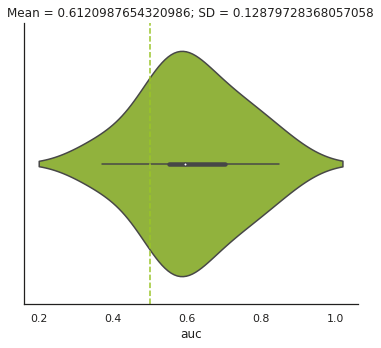

p_value = 0.03696303696303696


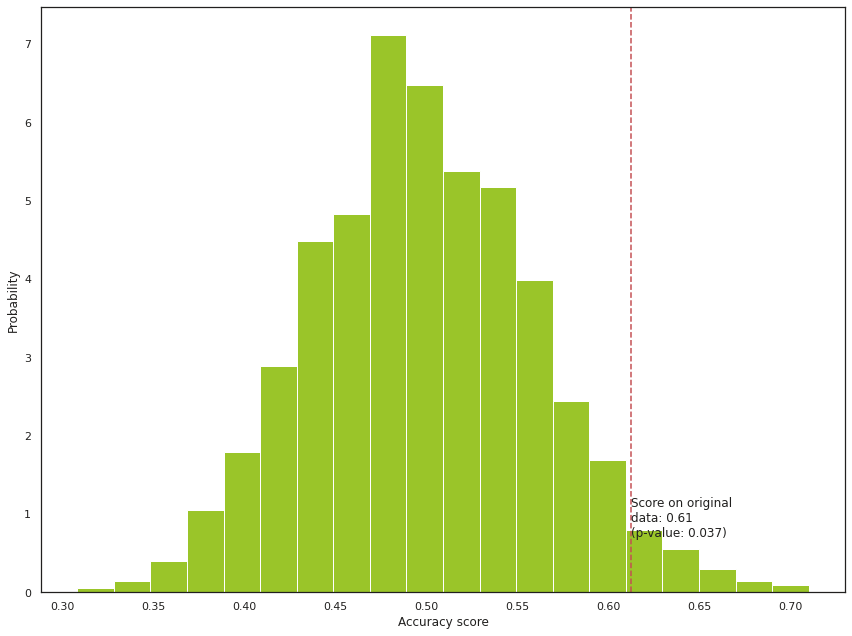

In [10]:
df_auc_mind = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind.drop('mind2', axis = 1).columns, 
                                 model = 'SVM', pca =False, n_components = 10,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)

df_auc_mind.to_csv('Data/multivariate_mind_segment.csv')

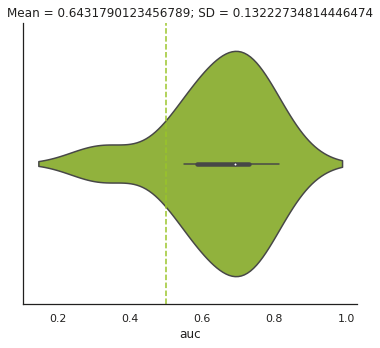

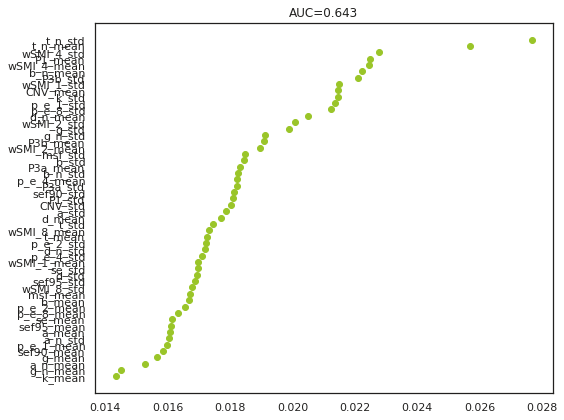

p_value = 0.00999000999000999


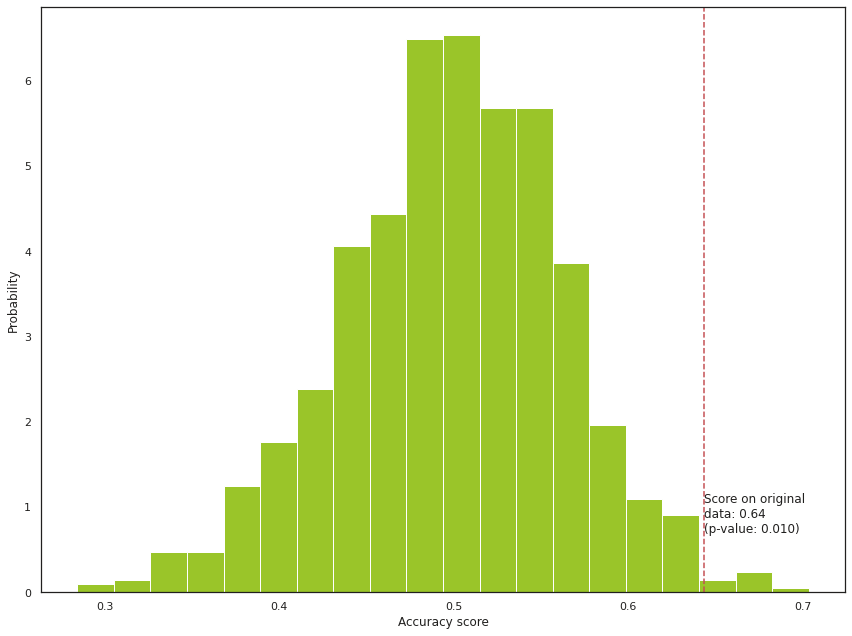

In [55]:
y, label = pd.factorize(df_mind['mind2'])
X = df_mind.drop('mind2', axis=1).astype('float32').values
n_estimators = 1000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features='auto', criterion='entropy',
        max_depth=None, random_state=42, class_weight=None))

cv = StratifiedKFold(10, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)

auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(df_mind.drop('mind2', axis = 1).columns)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(len(df_mind.drop('mind2', axis = 1).columns)))
plt.yticks(np.arange(len(df_mind.drop('mind2', axis = 1).columns)), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()


score, perm_scores, pvalue = permutation_test_score(
    doc_forest, X, y, scoring="roc_auc", cv=cv, n_permutations=1000, random_state = 42, n_jobs= -1
)


print(f"p_value = {pvalue}")

plt.hist(perm_scores, bins=20, density=True)
plt.axvline(score, ls="--", color="r")
score_label = (
    f"Score on original\ndata: {score:.2f}\n" f"(p-value: {pvalue:.3f})"
)
plt.text(score, np.max(perm_scores), score_label, fontsize=12)
plt.xlabel("Accuracy score")
plt.ylabel("Probability")
plt.show()

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [29]:
agg_dict = {k:['mean','std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_mw.columns = df_mw.columns.map("_".join)

df_mw  = (df_mw
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'probe', 'segment'], axis = 1) 
           )

{'SVM__C': 10, 'SVM__gamma': 0.001}


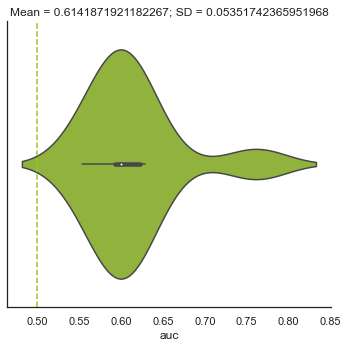

p_value = 0.000999000999000999


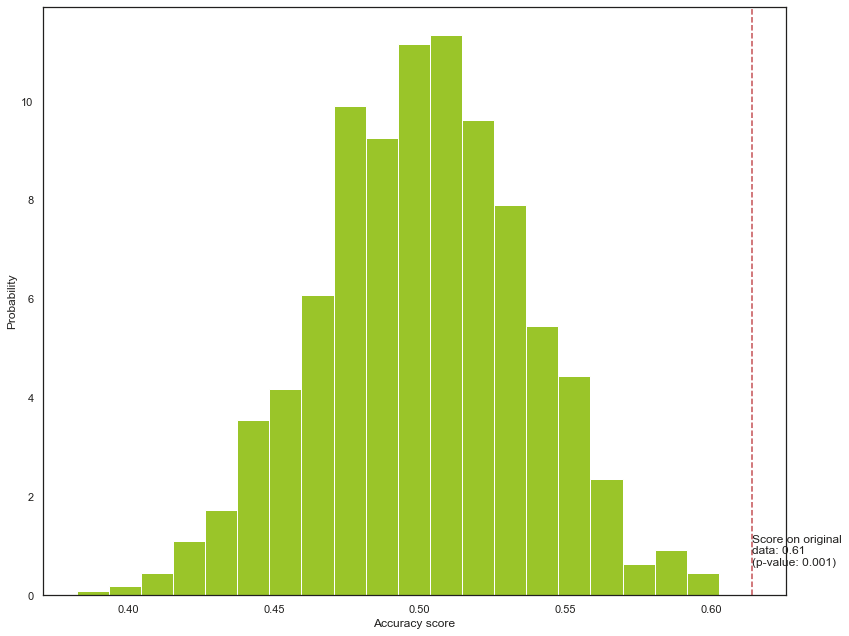

In [30]:
df_auc_mw = multivariate_classifier(data = df_mw, label = 'mind', features = df_mw.drop('mind', axis = 1).columns, 
                                 model = 'SVM', pca =False, n_components = 20,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)
df_auc_mw.to_csv('Data/multivariate_mw_segment.csv')

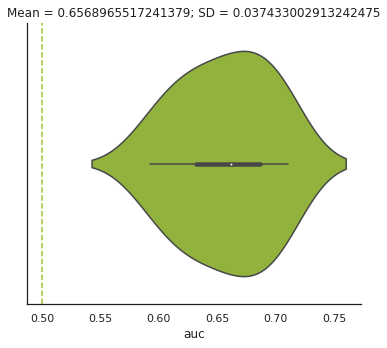

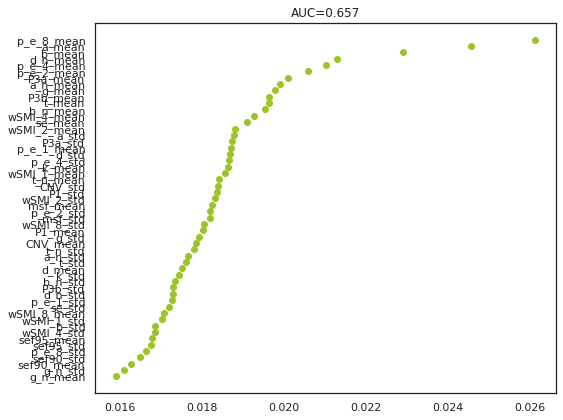

In [45]:
y, label = pd.factorize(df_mw['mind'])
X = df_mw.drop('mind', axis=1).astype('float32').values
n_estimators = 1000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features='auto', criterion='entropy',
        max_depth=None, random_state=42, class_weight=None))

cv = StratifiedKFold(10, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)

auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(df_mind.drop('mind2', axis = 1).columns)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(len(df_mind.drop('mind2', axis = 1).columns)))
plt.yticks(np.arange(len(df_mind.drop('mind2', axis = 1).columns)), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()

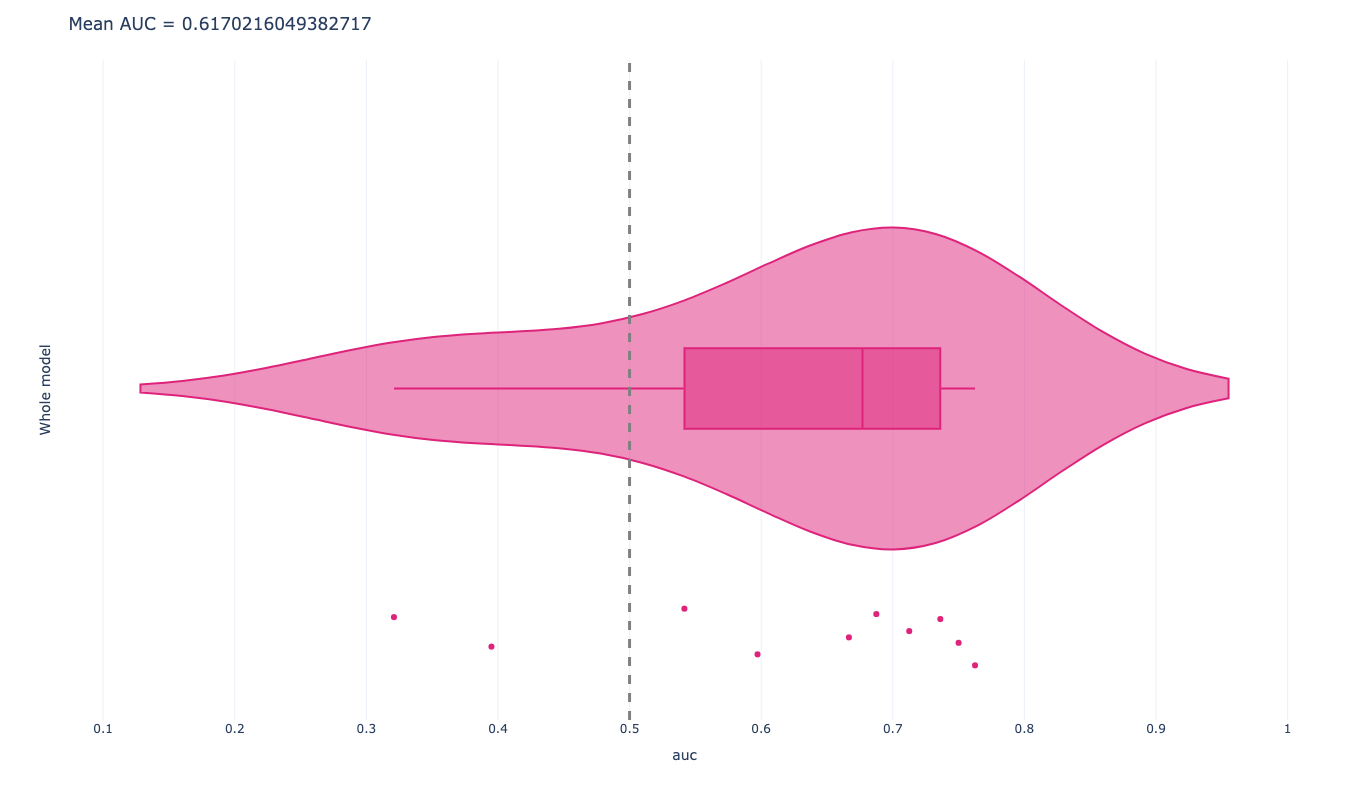

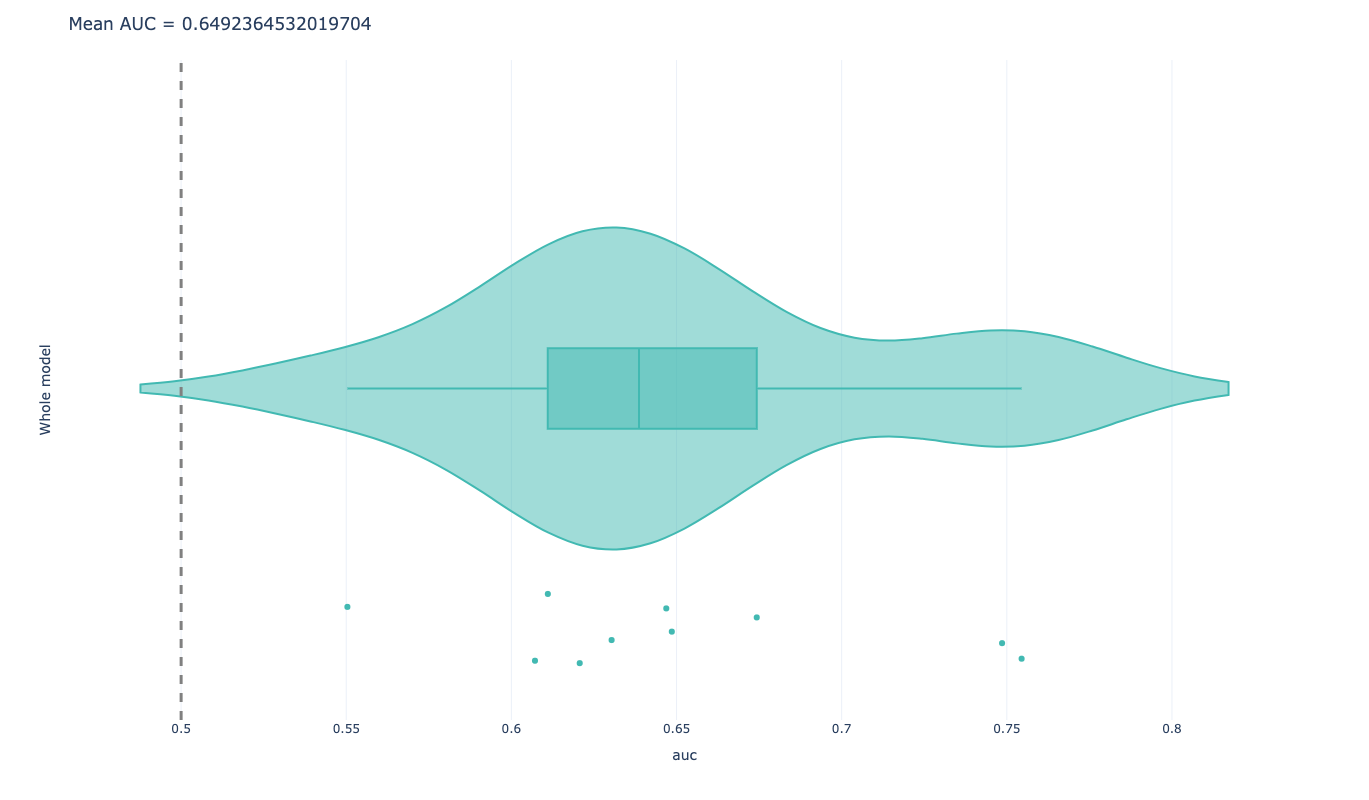

In [68]:
df_auc_mind = pd.read_csv('Data/multivariate_mind_segment.csv')
df_auc_mw= pd.read_csv('Data/multivariate_mw_segment.csv')

# df_segment = 

fig =px.violin(df_auc_mind, x = 'auc', box = True, points = 'all',template = "plotly_white", color_discrete_sequence = [pink])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    title = f'Mean AUC = {df_auc_mind.auc.mean()}',
    autosize=False,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()

fig =px.violin(df_auc_mw, x = 'auc', box = True, points = 'all',template = "plotly_white", color_discrete_sequence = [lblue])
fig.add_vline(x=0.5, line_width=3, line_dash="dash", line_color="grey")

fig.update_layout(
    title = f'Mean AUC = {df_auc_mw.auc.mean()}',
    autosize=False,
    width=800,
    height=800,
    yaxis = {'title': 'Whole model',
            'showticklabels': True,
            'tickmode': 'linear',
        }
)
fig.show()

## Probe Caught vs Self-Caught


In [23]:
agg_dict = {k:['mean', 'std'] for k in markers }
agg_dict.update({k:'first' for k in df_markers.drop(markers, axis=1).columns})

df_probe = (
    df_markers
    .query("mind != 'on-task'")
    .groupby(['segment', 'participant'], as_index = False).agg(agg_dict)
)

df_probe.columns = df_probe.columns.map("_".join)

df_probe  = (df_probe
            .rename(columns = {'participant_first':'participant', 'probe_first':'probe', 'mind_first':'mind', 'segment_first':'segment'})
            .drop(['participant', 'mind', 'segment'], axis = 1) 
           )


rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

probe_rus = rus.fit_resample(df_probe.drop('probe', axis = 1).astype("float32").values, df_probe.probe)

df_probe_rus = pd.DataFrame(probe_rus[0]).assign(probe = probe_rus[1])

{'SVM__C': 10, 'SVM__gamma': 0.01}


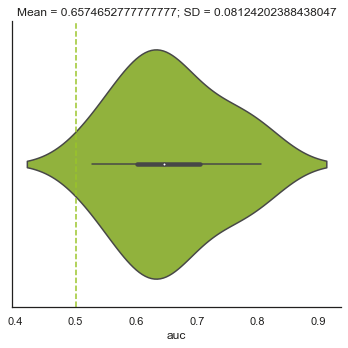

p_value = 0.004995004995004995


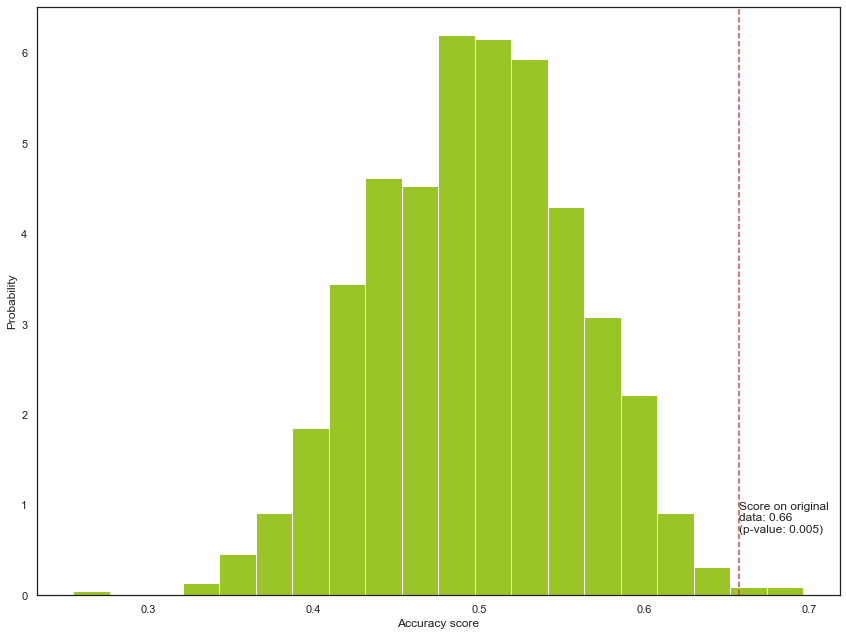

,auc
0,0.666667
1,0.652778
2,0.805556
3,0.527778
4,0.718750
5,0.593750
6,0.765625
7,0.640625
8,0.578125
9,0.625000


In [27]:
multivariate_classifier(data = df_probe_rus, label = 'probe', features = df_probe_rus.drop('probe', axis = 1).columns, 
                                 model = 'SVM', pca =False, n_components = 20,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)

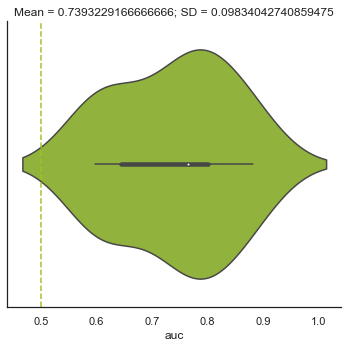

NameError: name 'df_mind' is not defined

In [32]:
y, label = pd.factorize(df_probe_rus['probe'])
X = df_probe_rus.drop('probe', axis = 1).astype('float32').values

n_estimators = 1000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features='auto', criterion='entropy',
        max_depth=None, random_state=42, class_weight=None))

cv = StratifiedKFold(10, shuffle=True, random_state = 42)


aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)), n_jobs = -1)

auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(df_mind.drop('mind2', axis = 1).columns)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(len(df_mind.drop('mind2', axis = 1).columns)))
plt.yticks(np.arange(len(df_mind.drop('mind2', axis = 1).columns)), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()

# By Trial Mulivariate analysis

## On-task Vs Mind- Wandering
This can only be performed for PC probes  as they are the only ones with On-task reports.

In [72]:
df_mind = (
    df_markers
    .query("probe == 'PC'")
    .assign(
    mind2 = lambda df: np.where(df.mind == 'on-task', 'on-task', 'mw'))
#     .query("mind != 'dMW'") #if you want to test against just one of the mw
    .drop(['participant', 'probe', 'mind', 'segment'], axis = 1) # drop mind or mind2 also
)

{'SVM__C': 10, 'SVM__gamma': 1}


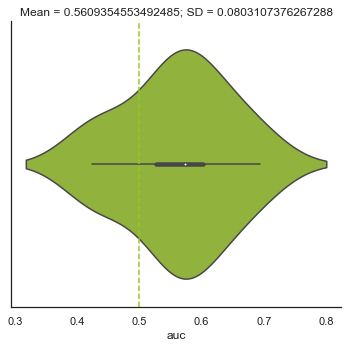

p_value = 0.024975024975024976


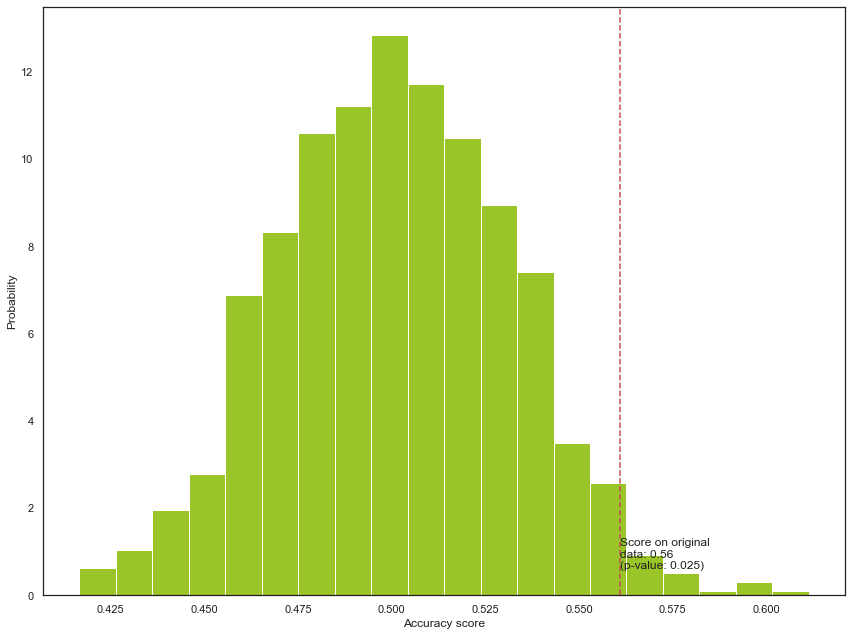

In [73]:
df_auc_mind_trial = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind.drop('mind2', axis = 1).columns, 
                                 model = 'SVM', pca =False, n_components = 10,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)

df_auc_mind_trial.to_csv('Data/multivariate_mind_trial.csv')

## dMW Vs sMW
This will be only performed in SC as they have more trials

In [74]:
df_mw = (
    df_markers
    .query("probe == 'SC'")
    .query("mind != 'on-task'")
    .drop(['participant', 'probe','segment'], axis = 1)
)

{'SVM__C': 10, 'SVM__gamma': 0.5}


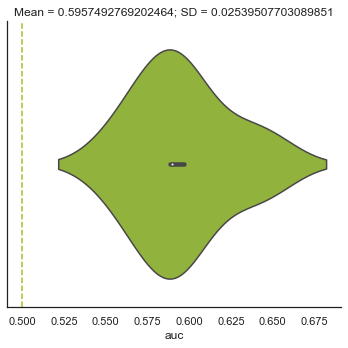

p_value = 0.000999000999000999


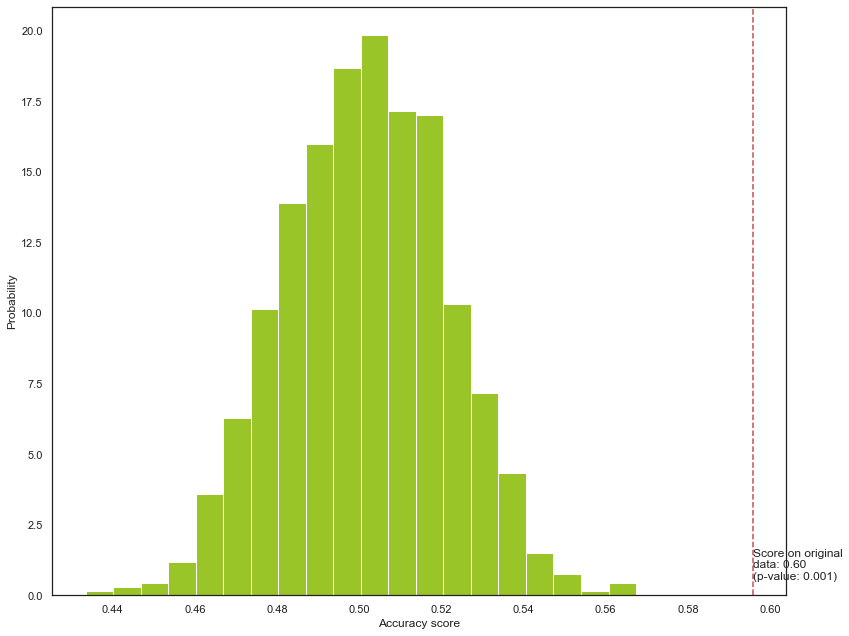

In [75]:
df_auc_mw_trial = multivariate_classifier(data = df_mw, label = 'mind', features =  df_mw.drop('mind', axis = 1).columns,
                                          model = 'SVM', grid_search = True, plot = True, permutation = True, n_permutations = 1000)

df_auc_mw_trial.to_csv('Data/multivariate_mw_trial.csv')

In [142]:
y, label = pd.factorize(df_mw['mind'])
X = df_mw.drop('mind', axis=1).astype('float32').values
n_estimators = 2000
doc_forest = make_pipeline(
    RobustScaler(),
    ExtraTreesClassifier(
        n_estimators=n_estimators, max_features=1, criterion='entropy',
        max_depth=4, random_state=42, class_weight='balanced'))

cv = GroupShuffleSplit(n_splits=50, train_size=0.8, test_size=0.2,
                       random_state=42)

aucs = cross_val_score(
    X=X, y=y, estimator=doc_forest,
    scoring='roc_auc', cv=cv, groups=np.arange(len(X)))

markers = df_mind.drop('mind2', axis = 1).columns

doc_forest.fit(X, y)
variable_importance = doc_forest.steps[-1][-1].feature_importances_
sorter = variable_importance.argsort()

# shorten the names a bit.
var_names = list(markers)
var_names = [var_names[ii]for ii in sorter]

# let's plot it
plt.figure(figsize=(8, 6))
plt.scatter(
    doc_forest.steps[-1][-1].feature_importances_[sorter],
    np.arange(17))
plt.yticks(np.arange(17), var_names)
plt.subplots_adjust(left=.46)
plt.title('AUC={:0.3f}'.format(np.mean(aucs)))
plt.show()

auc = pd.DataFrame(aucs, columns = ['auc'])
sns.catplot(x = 'auc', orient = 'h', data = auc, kind = 'violin')
plt.title(f'Mean = {np.mean(aucs)}; SD = {np.std(aucs)}')
plt.axvline(x = 0.5, linestyle = 'dashed')
plt.show()

# Multivariate only wih significant markers

In [45]:
svm_mind = pd.read_csv('Data/univariate_roc_mind_segment.csv')
aucs_mind = svm_mind.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})

svm_mw = pd.read_csv('Data/univariate_roc_mw_segment.csv')
aucs_mw = svm_mw.groupby('markers', as_index= False).agg({'AUC':'mean', 'significant':'first'})


significant_mind = aucs_mind.query("significant != 'p > 0.05'").markers.to_list()
# significant_mw = aucs_mw.query("significant != 'p > 0.05'").markers.to_list()
significant_mw = aucs_mw.query("significant == 'p < 0.05 FDR corrected'").markers.to_list()


significant_markers = significant_mind + significant_mw

{'SVM__C': 100, 'SVM__gamma': 0.001}


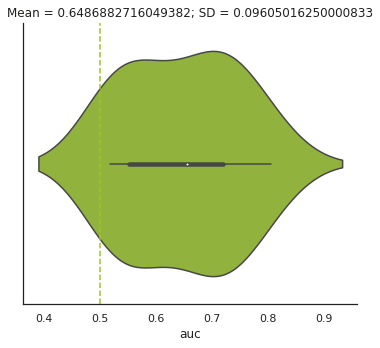

p_value = 0.002997002997002997


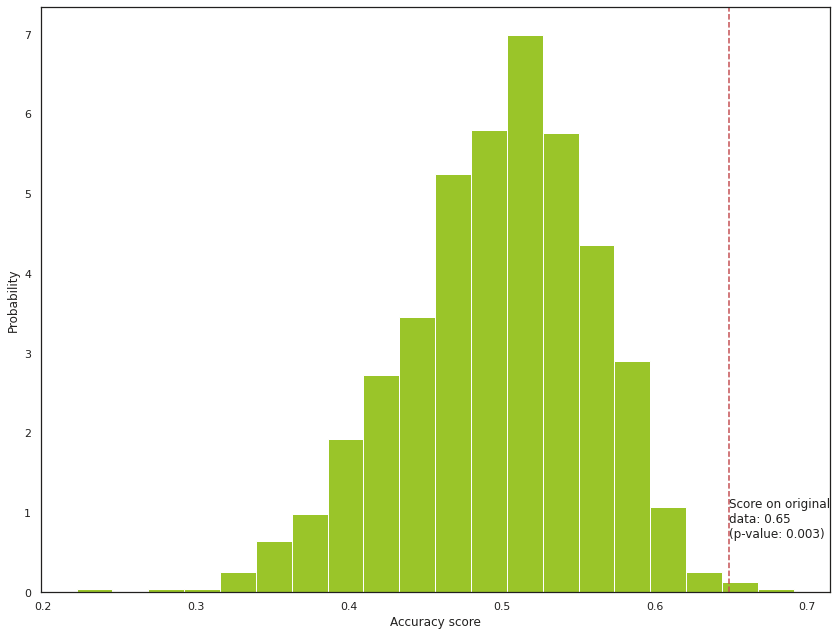

In [33]:
df_auc_mind_significants = multivariate_classifier(data = df_mind, label = 'mind2', features = df_mind[significant_mind].columns, 
                                 model = 'SVM', pca =False, n_components = 10,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)

df_auc_mind_significants.to_csv('Data/multivariate_mind_segment_significants.csv')

{'SVM__C': 10, 'SVM__gamma': 0.01}


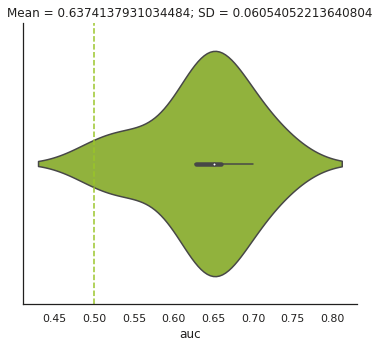

p_value = 0.000999000999000999


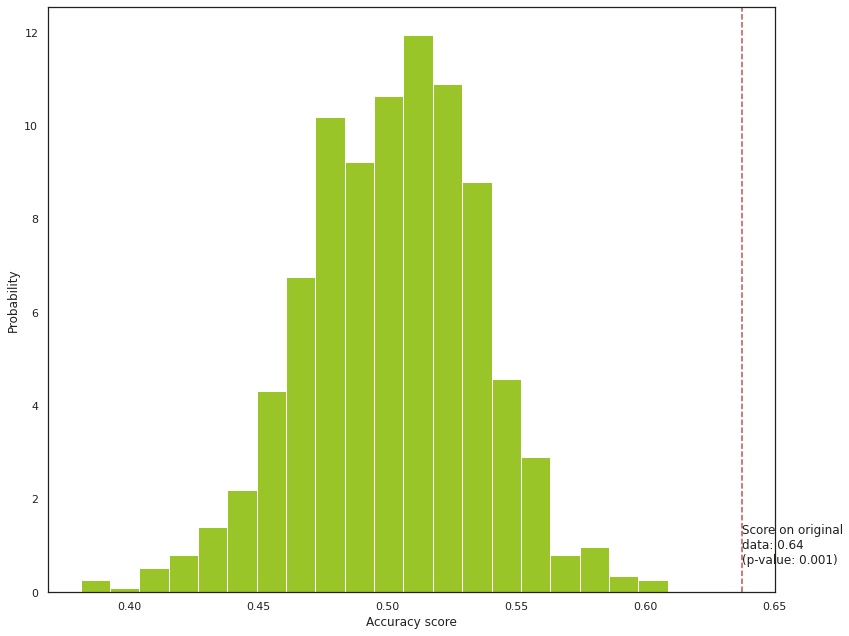

In [46]:
df_auc_mw_significants = multivariate_classifier(data = df_mw, label = 'mind', features = df_mw[significant_mw].columns, 
                                 model = 'SVM', pca =False, n_components = 20,
                                 cv_splits= 10,grid_search = True, 
                                 permutation = True, n_permutations = 1000)

df_auc_mw_significants.to_csv('Data/multivariate_mw_segment_significants.csv')